# What has been published about ethical and social science considerations?
## COVID-19 Open Research Dataset Challenge (CORD-19)

Let's try to find what people are talking in the COVID-19 papers about ethical and social science.
In this approach we are going to try a unsupervisioned method to find articles that match our need.
This can be useful to save time when we have a lot of data.

Note: Blunt first attempt - open to feedback.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os

#### First, load the data

In [2]:
metadata = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')

In [3]:
metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
cord_uid                       51078 non-null object
sha                            38022 non-null object
source_x                       51078 non-null object
title                          50920 non-null object
doi                            47741 non-null object
pmcid                          41082 non-null object
pubmed_id                      37861 non-null float64
license                        51078 non-null object
abstract                       42352 non-null object
publish_time                   51070 non-null object
authors                        48891 non-null object
journal                        46368 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_pdf_parse                  51078 non-null bool
has_pmc_xml_parse              51078 non-null bool
full_text_file                 42511 non-null ob

#### Let's see if we can find anything using the papers abstract

In [5]:
metadata_filter = metadata[metadata.abstract.str.contains('ethics|ethical|social science|multidisciplinary research', 
                                                          regex= True, na=False)].reset_index(drop=True)

In [6]:
len(metadata_filter)

282

#### We found 282 articles, lets take a look into one.

In [7]:
metadata_filter.abstract[1]

"BACKGROUND: Priority setting is one of the most difficult issues facing hospitals because of funding restrictions and changing patient need. A deadly communicable disease outbreak, such as the Severe Acute Respiratory Syndrome (SARS) in Toronto in 2003, amplifies the difficulties of hospital priority setting. The purpose of this study is to describe and evaluate priority setting in a hospital in response to SARS using the ethical framework 'accountability for reasonableness'. METHODS: This study was conducted at a large tertiary hospital in Toronto, Canada. There were two data sources: 1) over 200 key documents (e.g. emails, bulletins), and 2) 35 interviews with key informants. Analysis used a modified thematic technique in three phases: open coding, axial coding, and evaluation. RESULTS: Participants described the types of priority setting decisions, the decision making process and the reasoning used. Although the hospital leadership made an effort to meet the conditions of 'accounta

#### We can read all 282 of then, or we can use unsupervisioned learning to find patterns inside the text.
#### First let's prepare the data, removing anything that is not a word, and removing common words (stopwords)

In [8]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

metadata_filter['clean_abstract'] = metadata_filter['abstract'].apply(clean_text)

#### Now lets transform the words into a word matrix

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(metadata_filter['clean_abstract'])

#### Let's see if we have too many different subjects before getting the keywords. We use TSNE to reduce the word matrix to 2 dimensions, so we can plot the results.

In [10]:
tsne = TSNE(perplexity=4, random_state=42)

X_tsne = tsne.fit_transform(X)
X_tsne = pd.DataFrame(data=X_tsne, columns=['D1', 'D2'])

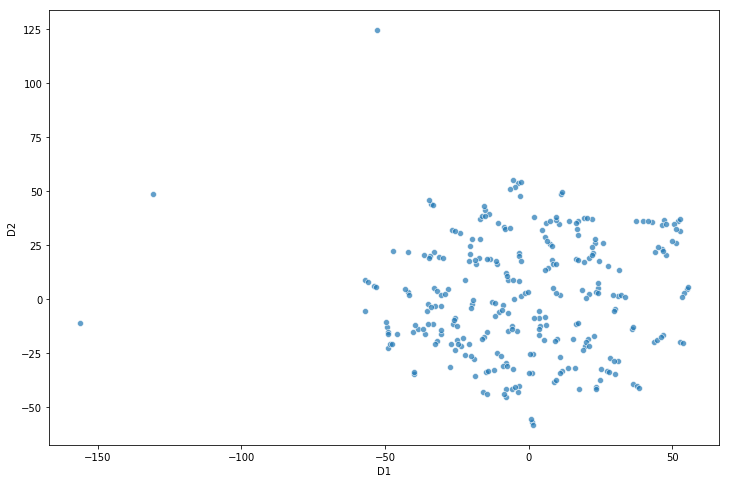

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(ax=ax,x = 'D1', y = 'D2', data=X_tsne, alpha=0.7)
plt.show()

#### We can see that we may have a central cluster and other sparse elements. Let's see if this is a real cluster

In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

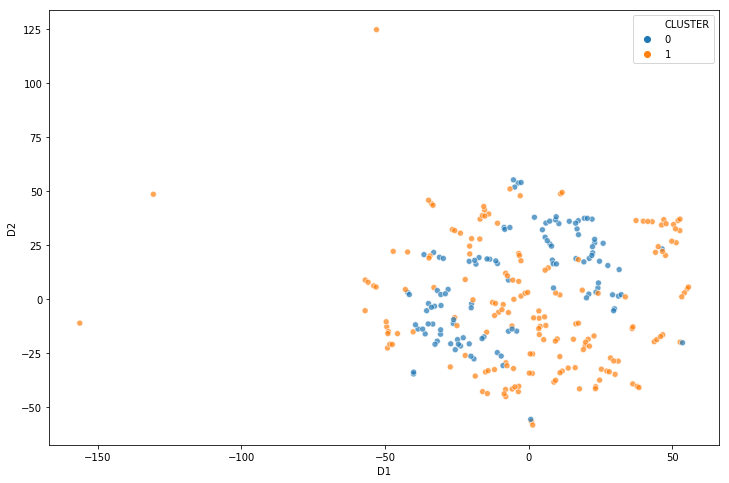

In [13]:
X_tsne['CLUSTER'] = kmeans.predict(X)

fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(ax=ax,x = 'D1', y = 'D2', hue = 'CLUSTER', data=X_tsne, alpha=0.7)
plt.show()

#### We have a little separation (not the best one... maybe if we had more data it could be better) but let's work with it. Let's add the cluster information into the metadata DF

In [14]:
metadata_filter['cluster'] = kmeans.predict(X)
metadata_filter.groupby('cluster')['cluster'].count()

cluster
0    112
1    170
Name: cluster, dtype: int64

#### Now let's try to find the subject to each cluster. We count how many time a word appear and run a LDA to group important words

In [15]:
X1 = metadata_filter.loc[metadata_filter['cluster'] == 0, 'clean_abstract']
X2 = metadata_filter.loc[metadata_filter['cluster'] == 1, 'clean_abstract']

tf_vectorizer1 = CountVectorizer(max_features=2000, stop_words='english')
tf_vectorizer2 = CountVectorizer(max_features=2000, stop_words='english')

X1 = tf_vectorizer1.fit_transform(X1)
X2 = tf_vectorizer2.fit_transform(X2)

lda1 = LatentDirichletAllocation(n_components=5, random_state=42)
lda2 = LatentDirichletAllocation(n_components=5, random_state=42)

lda1.fit(X1)
lda2.fit(X2)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Now let's print the main topics and their keywords

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [17]:
print_top_words(lda1, tf_vectorizer1.get_feature_names(), 5)

Topic #0: health public care ethical ethics
Topic #1: care patients evd physicians ethical
Topic #2: pandemic influenza ethical care issues
Topic #3: health public care ethical medical
Topic #4: health ethical public control care


In [18]:
print_top_words(lda2, tf_vectorizer2.get_feature_names(), 5)

Topic #0: disease research infectious social diseases
Topic #1: infection review research covid ethical
Topic #2: studies data patients clinical study
Topic #3: research health human ethical disease
Topic #4: risk health factors research patients


#### We can see that the first cluster (the bigger one) has more subjects that we want, while the second has more clinical data.
#### We went from 51078 articles to 112, so this method could be useful to optimize the search for important articles. We could use the full text, or add more words to the regex search, but for now is a good first try.